"Can you accurately predict precipitation levels in Brazzaville's complex climate?"

Accurate precipitation forecasting is vital for urban planning, agriculture, water resource management, and disaster prevention. In Brazzaville, the capital of the Republic of Congo, rainfall patterns are highly variable, leading to flash floods, crop damage, and infrastructural stress. However, high-resolution, localised forecasting tools are often lacking in many sub-Saharan African cities due to sparse data and limited modeling infrastructure.

This challenge aims to develop amachine learning model that can predict daily or sub-daily precipitation levels in Brazzaville using meteorological and spatio-temporal data.

In [1]:
import numpy as np
import pandas as pd

import os, shutil, tqdm
from tqdm.autonotebook import trange, tqdm

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns

import sklearn
import feature_engine
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.transformation import YeoJohnsonTransformer, PowerTransformer, LogCpTransformer, BoxCoxTransformer
from feature_engine.selection import DropConstantFeatures,DropCorrelatedFeatures, DropDuplicateFeatures
from feature_engine.outliers import OutlierTrimmer

import warnings

C:\Users\USER\AppData\Local\Temp\ipykernel_4980\1152912368.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange, tqdm


In [2]:
pd.options.display.max_colwidth = 500
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

path = "data"

train_df = pd.read_csv(os.path.join(path, "Train_data.csv"))
test_df = pd.read_csv(os.path.join(path, "Test_data.csv"))
samp_sub = pd.read_csv(os.path.join(path, "SampleSubmission.csv"))
var_def = pd.read_csv(os.path.join(path, "VariableDefinitions.csv"))

train_df.shape, test_df.shape, var_def.shape

((3579, 13), (1535, 12), (9, 3))

In [3]:
display(train_df.sample(3), test_df.sample(3))

,ID,YEAR,MO,DY,WS2M,T2M,T2MDEW,T2MWET,Target,RH2M,PS,QV2M,DATE
3242,ID_Myd0aF_20120503,2012,5,3,1.08,24.79,21.90,23.34,7.86,85.00,96.16,17.17,2012-05-03
1522,ID_oIepq3_20130919,2013,9,19,1.58,26.50,20.78,23.64,0.04,72.26,96.09,16.03,2013-09-19
610,ID_OU9lHM_20140610,2014,6,10,0.98,24.67,21.16,22.91,0.15,81.71,96.23,16.39,2014-06-10


,ID,YEAR,MO,DY,WS2M,T2M,T2MWET,T2MDEW,RH2M,PS,QV2M,DATE
207,ID_99CQPK_20131006,2013,10,6,0.97,25.39,23.25,21.11,78.23,96.16,16.35,2013-10-06
165,ID_vUeMFZ_20200727,2020,7,27,2.26,23.12,21.36,19.60,82.03,96.26,14.87,2020-07-27
220,ID_NTB2QQ_20230509,2023,5,9,0.93,26.02,24.45,22.89,83.57,96.05,18.28,2023-05-09


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3579 entries, 0 to 3578
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      3579 non-null   object 
 1   YEAR    3579 non-null   int64  
 2   MO      3579 non-null   int64  
 3   DY      3579 non-null   int64  
 4   WS2M    3579 non-null   float64
 5   T2M     3579 non-null   float64
 6   T2MDEW  3579 non-null   float64
 7   T2MWET  3579 non-null   float64
 8   Target  3579 non-null   float64
 9   RH2M    3579 non-null   float64
 10  PS      3579 non-null   float64
 11  QV2M    3579 non-null   float64
 12  DATE    3579 non-null   object 
dtypes: float64(8), int64(3), object(2)
memory usage: 363.6+ KB


In [5]:
def get_id(col):
    return col.split("_")[0] + "_" + col.split("_")[1]

train_df["id"] = train_df["ID"].apply(get_id)
test_df["id"] = test_df["ID"].apply(get_id)

train_df = train_df.set_index("ID")
test_df = test_df.set_index("ID")

In [6]:
train_df.sample()

,YEAR,MO,DY,WS2M,T2M,T2MDEW,T2MWET,Target,RH2M,PS,QV2M,DATE,id
ID,,,,,,,,,,,,,
ID_oeR6AW_20200525,2020,5,25,1.0,25.87,22.09,23.98,1.47,80.42,96.23,17.37,2020-05-25,ID_oeR6AW


<Axes: >

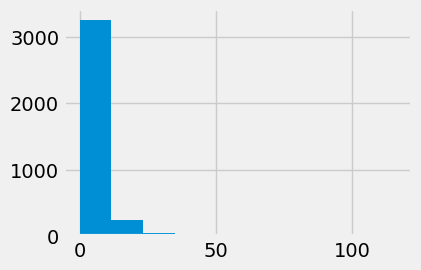

In [7]:
train_df["Target"].hist(figsize=(4,2.8))

In [8]:
df = pd.concat([train_df, test_df], axis = 0).sort_values("DATE", ascending = True)
df.shape

(5114, 13)

In [9]:
df.head()

,YEAR,MO,DY,WS2M,T2M,T2MDEW,T2MWET,Target,RH2M,PS,QV2M,DATE,id
ID,,,,,,,,,,,,,
ID_ld4rFC_20100101,2010,1,1,0.80,25.28,21.26,23.27,5.33,79.23,96.12,16.52,2010-01-01,ID_ld4rFC
ID_XSXgYV_20100102,2010,1,2,0.60,25.80,21.48,23.64,8.73,77.64,96.13,16.75,2010-01-02,ID_XSXgYV
ID_fXEbuS_20100103,2010,1,3,0.84,25.40,21.79,23.60,10.99,81.03,96.12,17.06,2010-01-03,ID_fXEbuS
ID_lSWwaf_20100104,2010,1,4,0.89,25.35,21.96,23.65,9.88,82.50,96.09,17.24,2010-01-04,ID_lSWwaf
ID_EtbvPr_20100105,2010,1,5,1.17,24.54,22.03,23.28,8.68,86.36,96.11,17.31,2010-01-05,ID_EtbvPr


array([[<Axes: title={'center': 'YEAR'}>, <Axes: title={'center': 'MO'}>,
        <Axes: title={'center': 'DY'}>],
       [<Axes: title={'center': 'WS2M'}>,
        <Axes: title={'center': 'T2M'}>,
        <Axes: title={'center': 'T2MDEW'}>],
       [<Axes: title={'center': 'T2MWET'}>,
        <Axes: title={'center': 'Target'}>,
        <Axes: title={'center': 'RH2M'}>],
       [<Axes: title={'center': 'PS'}>, <Axes: title={'center': 'QV2M'}>,
        <Axes: >]], dtype=object)

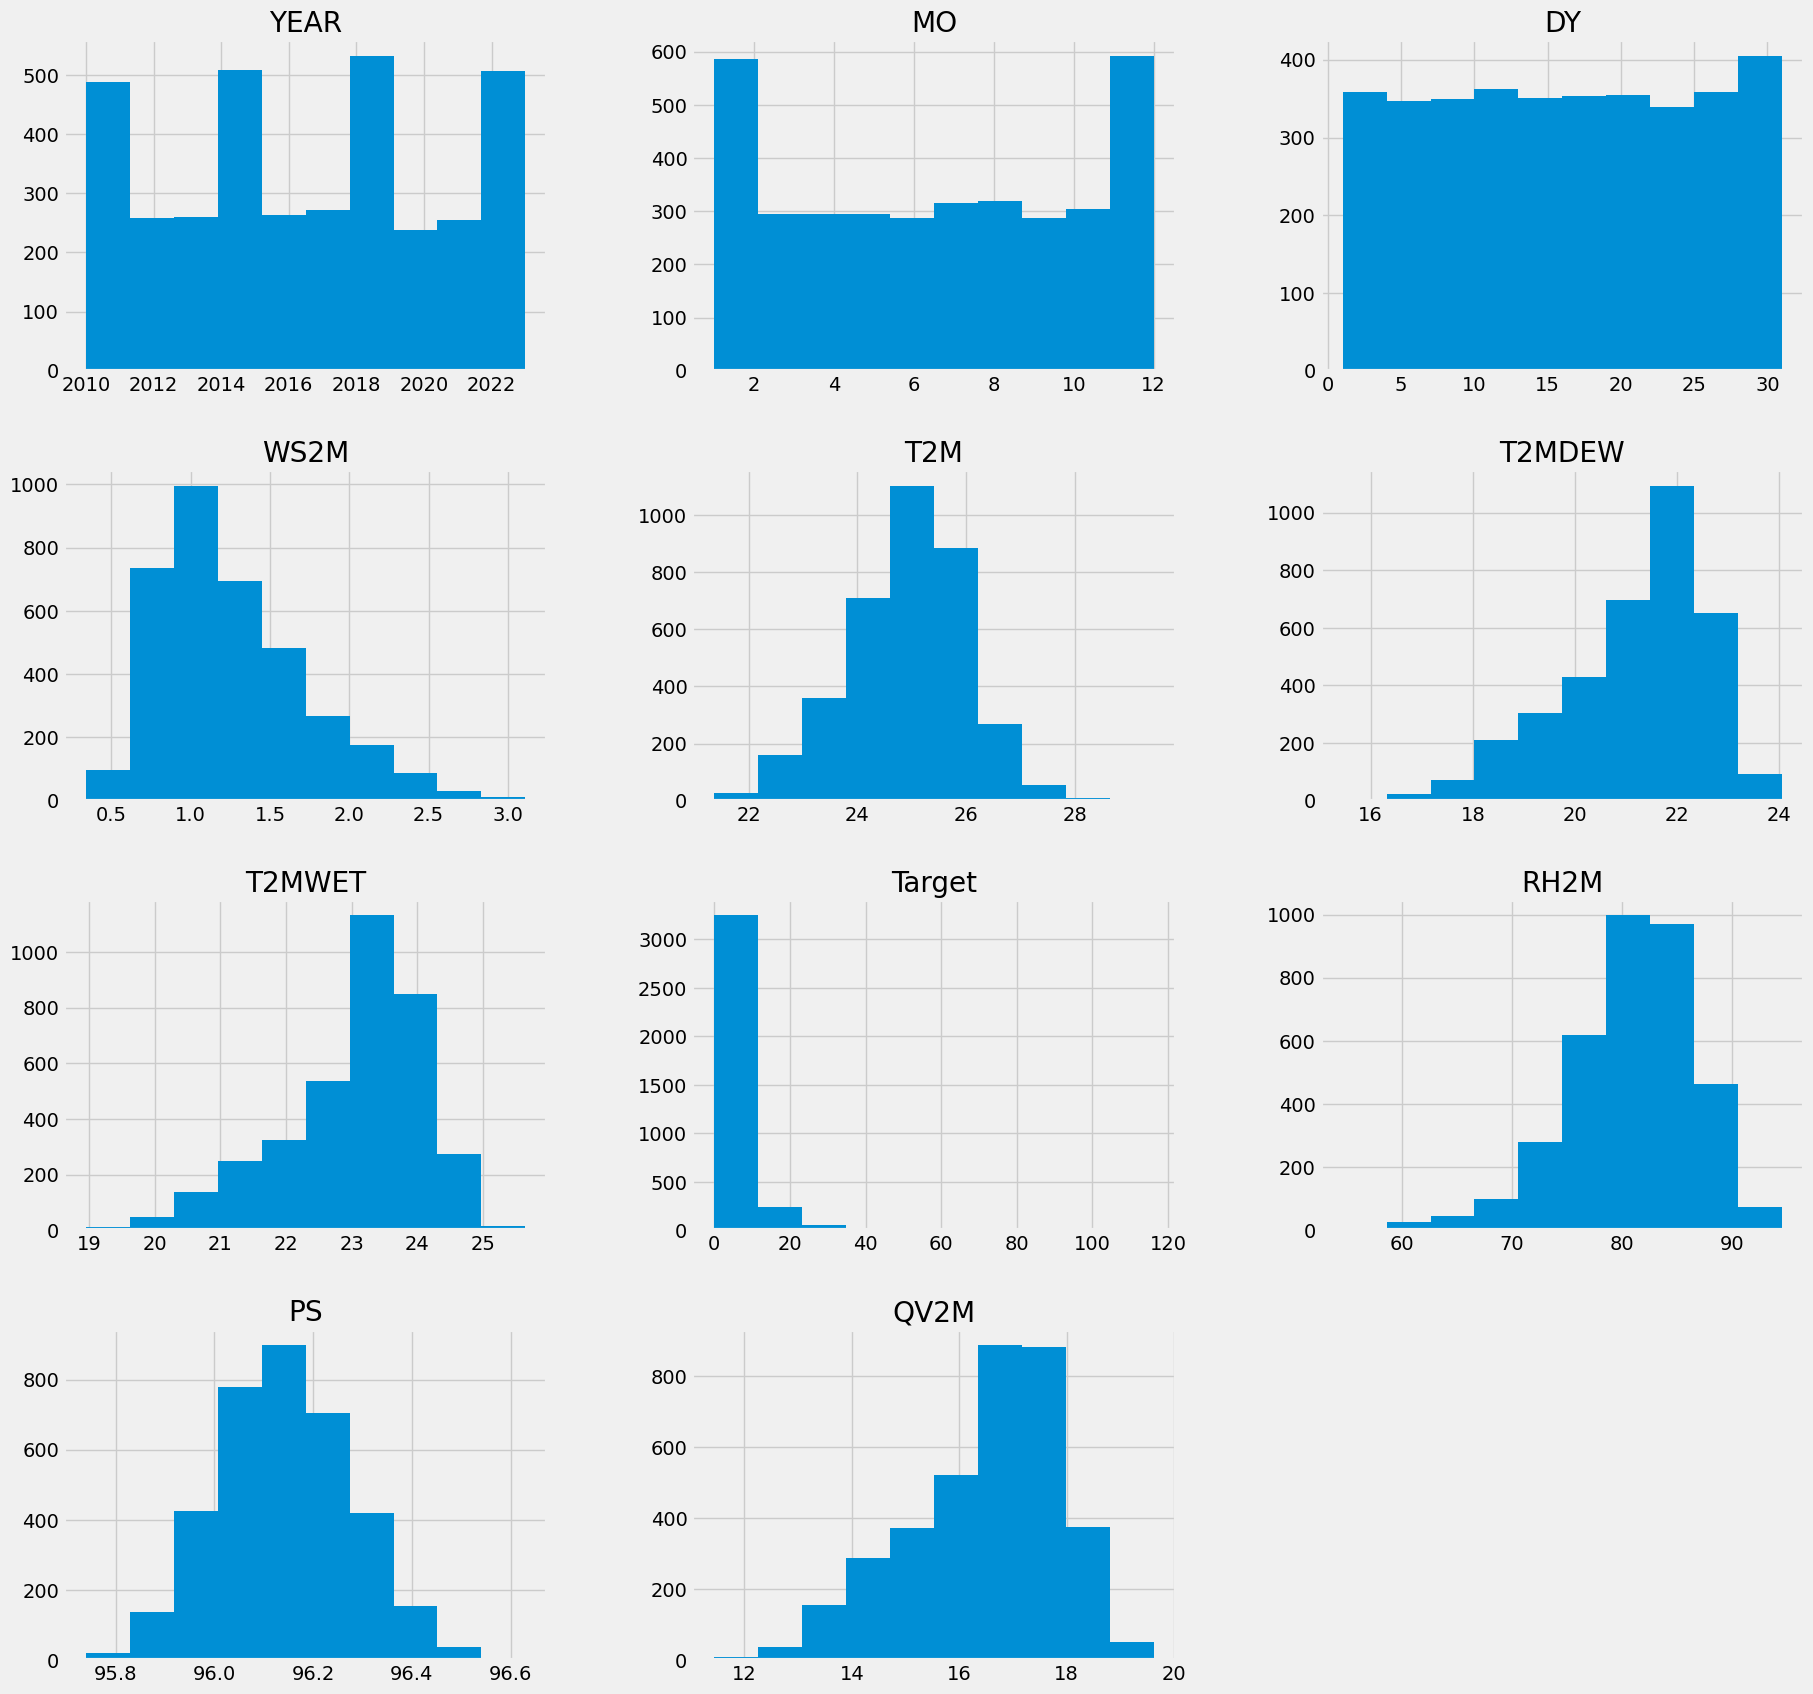

In [10]:
train_df.hist(figsize = (20,20))

In [11]:
def plot_bar_against(x:str, y:str, df_:pd.DataFrame) -> None:
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,5))
    sns.barplot(x = x, y = y, data = df_, color = "navy", ax = ax, estimator = "mean", errorbar=('ci', 0))
    ax.tick_params(axis = "x", rotation = 45)
    ax.bar_label(ax.containers[0])
    if x == "MO":
        ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"])
    plt.show()

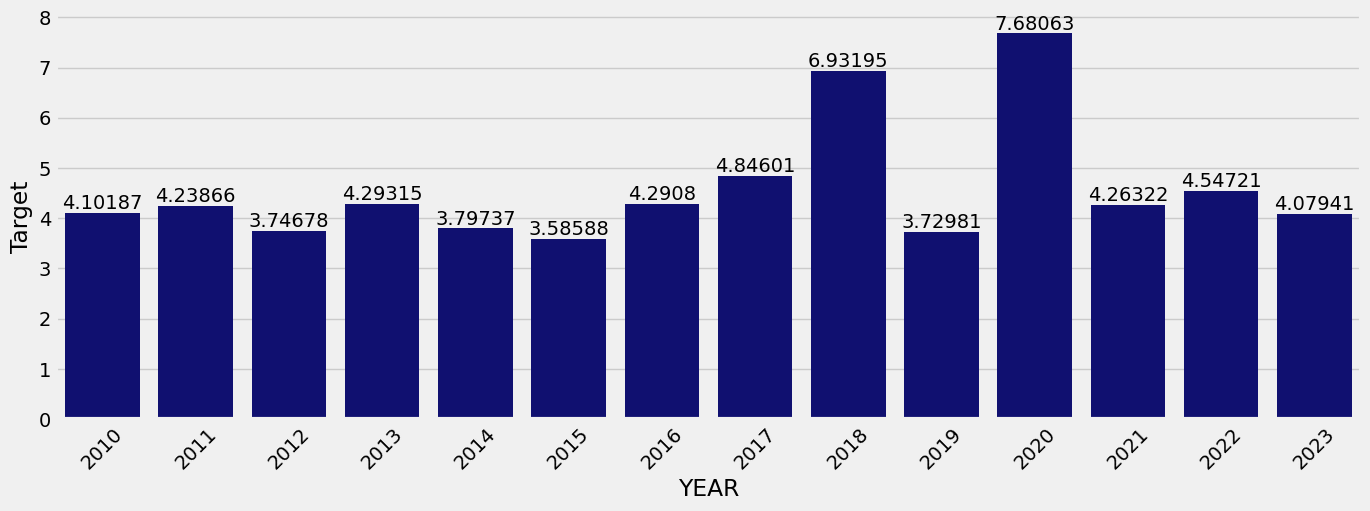

In [12]:
plot_bar_against(x = "YEAR", y = "Target", df_ = train_df)

C:\Users\USER\AppData\Local\Temp\ipykernel_4980\3338772134.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"])


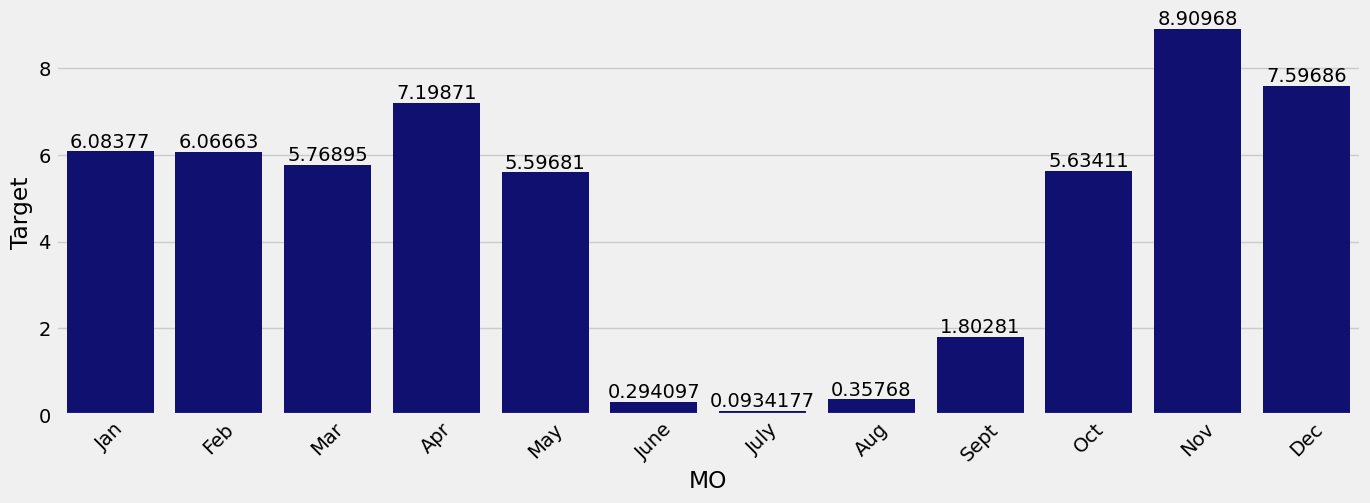

In [13]:
plot_bar_against(x = "MO", y = "Target", df_ = train_df)

<Axes: >

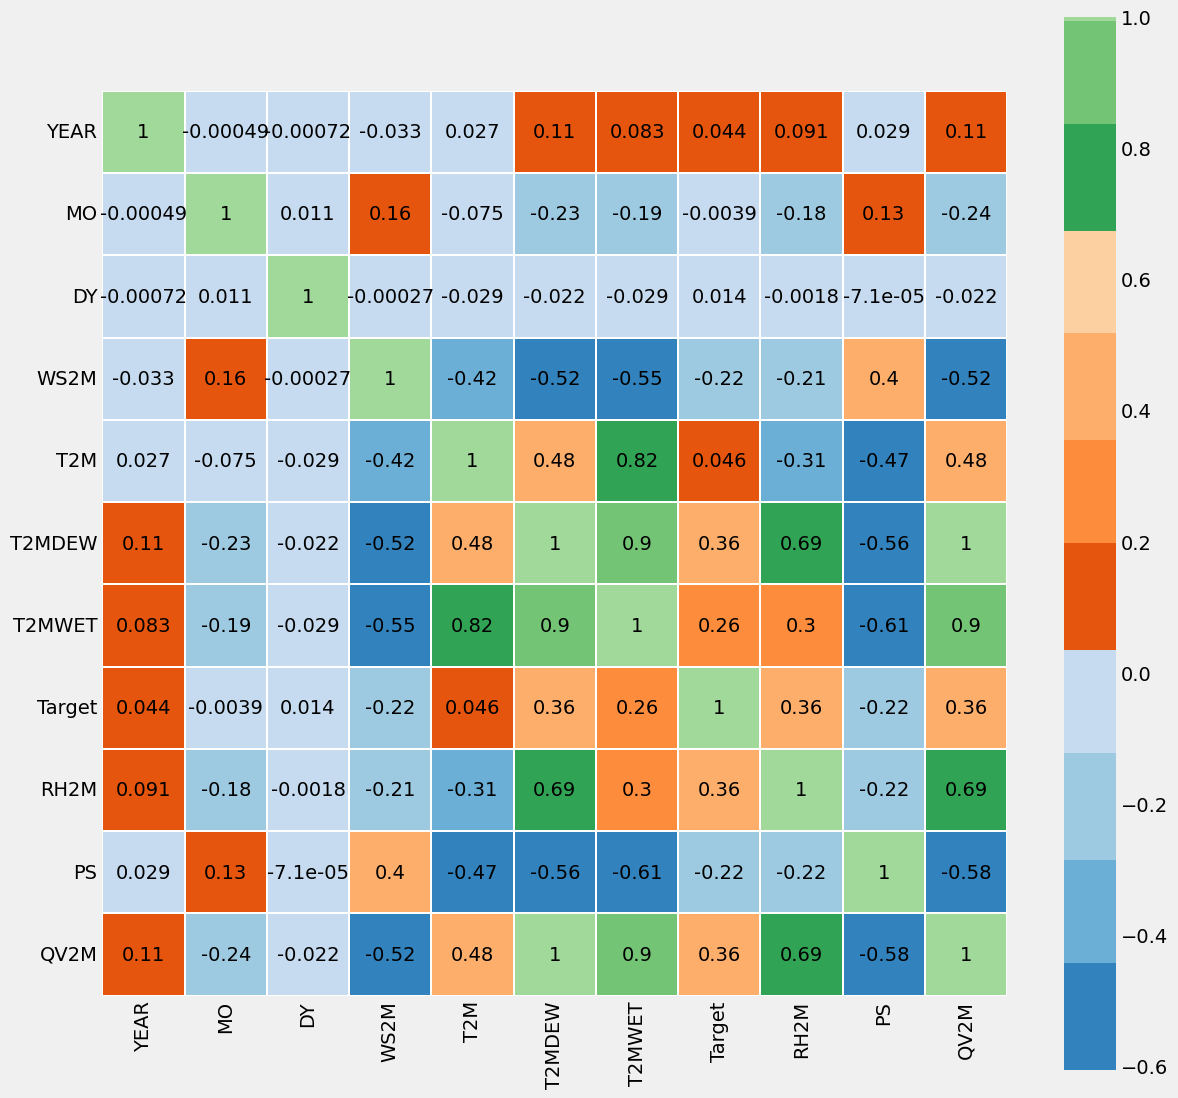

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (13,13))
sns.heatmap(df.drop(["DATE", "id"], axis = 1).corr(), annot = True, annot_kws = {"color": "black"}, center = True, square = True, lw = .3, ax = ax, cmap = "tab20c")

In [15]:
print(sorted(test_df["YEAR"].unique().tolist()))
print(sorted(train_df["YEAR"].unique().tolist()))

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [16]:
def engineer_features(df_:pd.DataFrame) -> pd.DataFrame:
    df_["Target"] = df_["Target"].fillna(value = -999)
    # df_["Target"] = df_["Target"].bfill().bfill()
    for step_ in tqdm([1,2,3,4,7,21,30]):
        df_[f"Target_lag_{step_}"] = df_["Target"].shift(periods = step_).bfill().bfill()
        for col_ in ["WS2M", "T2M", "T2MDEW", "T2MWET", "RH2M", "PS", "QV2M"]:
            df_[f"{col_}_lag_{step_}"] = df_[col_].shift(periods = step_).bfill().bfill()
    dcf = DropConstantFeatures(
        tol = 1
    )
    dccf = DropCorrelatedFeatures(
        threshold = .8
    )
    ddf = DropDuplicateFeatures(
        missing_values = "ignore"
    )
    dtf = DatetimeFeatures(
        variables = ["DATE"],
        drop_original = True,
        features_to_extract = ["month", "quarter", "year", "week", "day_of_month", "day_of_year"]
    )
    gcf = CyclicalFeatures(
        variables = ["DATE" + "_" + i for i in ["month", "day_of_year", "day_of_month"]]
    )

    df_ = ddf.fit_transform(df_)
    df_ = dtf.fit_transform(df_)
    df_ = dcf.fit_transform(df_)
    df_ = gcf.fit_transform(df_)
    df_ = dccf.fit_transform(df_)
    print("Constant Features: ", dcf.features_to_drop_)
    print("Correlated feature Pairs: ", dccf.correlated_feature_sets_)
    print("Duplicate Features: ", ddf.features_to_drop_)
    
    return df_

In [17]:
checksum = engineer_features(df_ = df)

100%|██████████| 7/7 [00:00<00:00, 221.15it/s]


Constant Features:  []
Correlated feature Pairs:  [{'DATE_day_of_month', 'DY'}, {'DATE_quarter', 'DATE_day_of_year', 'DATE_month', 'DATE_week', 'MO'}, {'DATE_day_of_year_cos', 'DATE_month_cos'}, {'DATE_day_of_year_sin', 'DATE_month_sin'}, {'DATE_year', 'YEAR'}, {'PS_lag_1', 'PS'}, {'PS_lag_3', 'PS_lag_2'}, {'T2MDEW', 'QV2M_lag_3', 'QV2M_lag_2', 'T2MWET', 'T2MDEW_lag_1', 'T2MWET_lag_1', 'T2MDEW_lag_2', 'QV2M_lag_4', 'T2MWET_lag_2', 'QV2M', 'QV2M_lag_1', 'T2MDEW_lag_3'}, {'T2MDEW_lag_21', 'T2MWET_lag_21', 'QV2M_lag_21'}, {'T2MWET_lag_30', 'QV2M_lag_30', 'T2MDEW_lag_30'}, {'T2MDEW_lag_4', 'T2MWET_lag_7', 'T2MDEW_lag_7', 'QV2M_lag_7'}, {'T2MWET_lag_3', 'T2MWET_lag_4', 'T2M_lag_3'}]
Duplicate Features:  set()


In [18]:
for col in checksum.columns:
    print(f"{col}: {checksum[col].nunique()}")

WS2M: 243
T2M: 571
Target: 1185
RH2M: 1990
PS: 86
QV2M: 666
id: 5114
Target_lag_1: 1185
WS2M_lag_1: 243
T2M_lag_1: 571
RH2M_lag_1: 1990
Target_lag_2: 1185
WS2M_lag_2: 243
T2M_lag_2: 571
RH2M_lag_2: 1989
PS_lag_2: 86
Target_lag_3: 1185
WS2M_lag_3: 243
T2MWET_lag_3: 540
RH2M_lag_3: 1989
Target_lag_4: 1185
WS2M_lag_4: 243
T2M_lag_4: 571
RH2M_lag_4: 1989
PS_lag_4: 86
Target_lag_7: 1183
WS2M_lag_7: 243
T2M_lag_7: 571
RH2M_lag_7: 1988
PS_lag_7: 86
QV2M_lag_7: 666
Target_lag_21: 1178
WS2M_lag_21: 243
T2M_lag_21: 570
RH2M_lag_21: 1987
PS_lag_21: 86
QV2M_lag_21: 666
Target_lag_30: 1178
WS2M_lag_30: 243
T2M_lag_30: 570
RH2M_lag_30: 1986
PS_lag_30: 86
QV2M_lag_30: 666
DATE_year: 15
DATE_day_of_month: 31
DATE_day_of_year: 366
DATE_day_of_year_sin: 316
DATE_day_of_year_cos: 327
DATE_day_of_month_sin: 31
DATE_day_of_month_cos: 25


In [19]:
for i in tqdm(["Target", "Target_lag_1", "Target_lag_2", "Target_lag_4", "Target_lag_7", "Target_lag_21", "Target_lag_30"]):
    checksum[i] = checksum[i].replace(-999, np.nan)

for i in tqdm(["Target_lag_1", "Target_lag_2", "Target_lag_4", "Target_lag_7", "Target_lag_21", "Target_lag_30"]):
    checksum[i] = checksum[i].bfill().bfill()

100%|██████████| 6/6 [00:00<00:00, 1808.93it/s]


In [20]:
checksum[["Target", "Target_lag_1", "Target_lag_2", "Target_lag_4", "Target_lag_7", "Target_lag_21", "Target_lag_30"]].agg(["min", "max", "mean"])

,Target,Target_lag_1,Target_lag_2,Target_lag_4,Target_lag_7,Target_lag_21,Target_lag_30
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,116.180000,116.180000,116.180000,116.180000,116.180000,116.180000,116.180000
mean,4.572283,4.631299,4.631435,4.632202,4.628469,4.628342,4.623784


In [21]:
train_df = checksum[checksum["Target"].notna()]
test_df = checksum[checksum["Target"].isna()].drop("Target", axis = 1)

train_df.shape, test_df.shape

((3579, 50), (1535, 49))

In [22]:
X_train = train_df.drop(["Target", "id", "DATE_year"], axis = 1)
X_test = test_df.copy().drop(["id", "DATE_year"], axis = 1)
y_train = train_df[["Target"]]

float(np.mean(X_train.columns == X_test.columns))

1.0

In [23]:
import xgboost, catboost, lightgbm
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from xgboost import plot_importance as xg_plot_importance
from lightgbm.plotting import plot_importance as lg_plot_importance

from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn import metrics

In [24]:
def plot_importance(plot_fn, model):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 12))
    plot_fn(model, ax = ax)

In [25]:
cbr = CatBoostRegressor(verbose = 0)
xgr = XGBRegressor()
lgr = LGBMRegressor(verbose = -1)
rfr = RandomForestRegressor()
vr = VotingRegressor(
    estimators = [("xgr",xgr), ("cbr",cbr), ("lgr", lgr), ("rfr", rfr)]
)
sr = StackingRegressor(
    estimators = [("xgr",xgr), ("cbr",cbr), ("lgr", lgr), ("rfr", rfr)]
)

In [26]:
def cv(model, X, y, model_name:str):
    print(f"-> Running for {model_name}")
    cv = KFold(n_splits=5)
    neg_rmse = cross_val_score(
        estimator = model,
        X = X,
        y = y,
        cv = cv,
        scoring = "neg_root_mean_squared_error"
    )
    rmse = -np.mean(neg_rmse)
    print(f"rmse for {model_name}: {rmse} \n")

In [27]:
warnings.filterwarnings("ignore")
for model_, model_name_ in zip([xgr, cbr, lgr, rfr, sr, vr][:1], ["xgboost", "catboost", "lightgbm", "random forest", "Stacking regressor", "voting regressor"][:1]):
    cv(model_, X_train, y_train, model_name_)

-> Running for xgboost
rmse for xgboost: 6.388509798049927 



In [28]:
for model in [xgr, cbr, lgr, rfr][:-1]:
    model.fit(X_train, y_train)

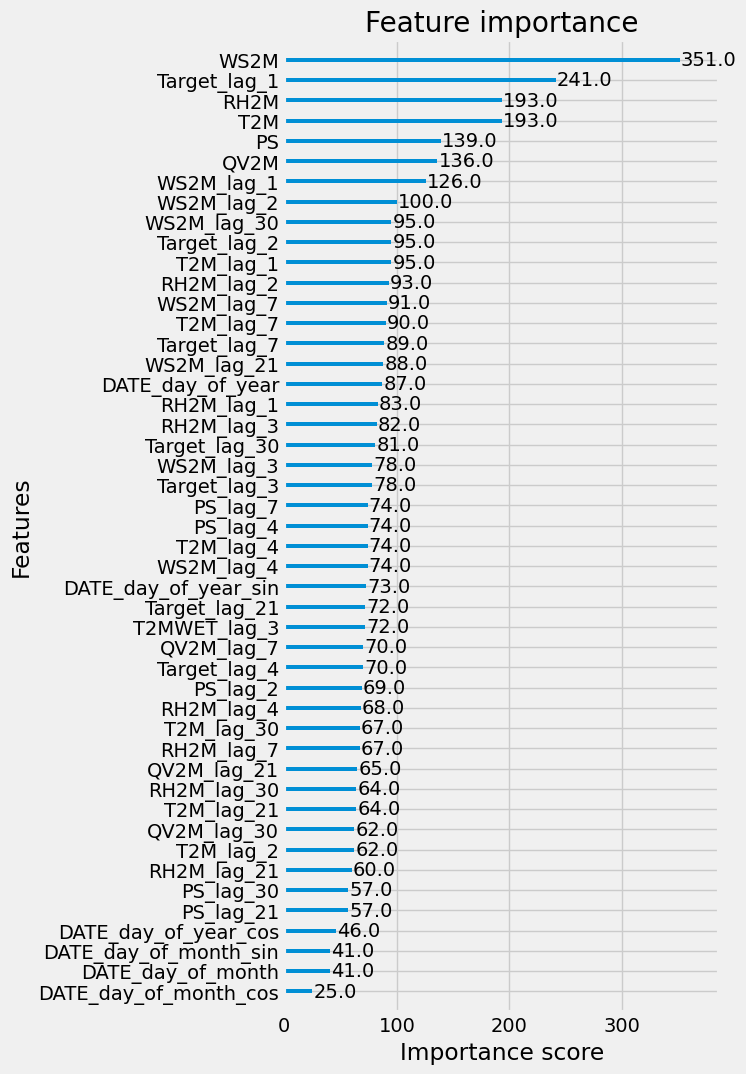

In [29]:
plot_importance(xg_plot_importance, model = xgr)

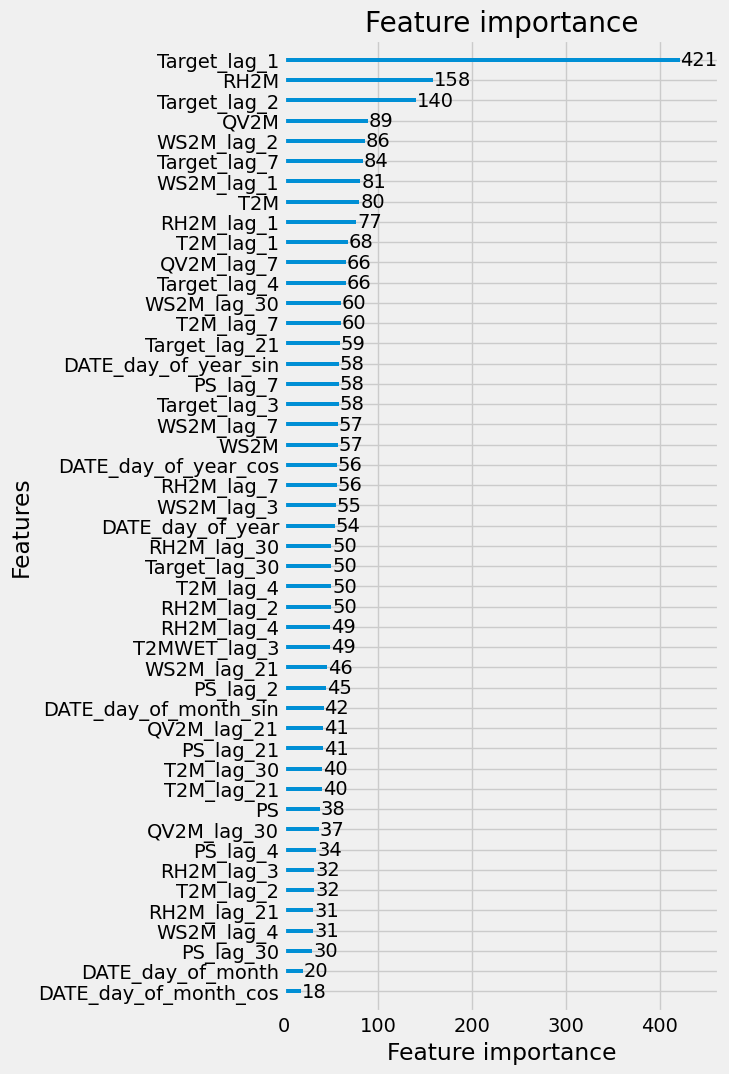

In [30]:
plot_importance(lg_plot_importance, model = lgr)

In [31]:
if os.path.exists("subs"):
    print("submission directory exists already!!")
else:
    os.makedirs("subs")

submission directory exists already!!


In [32]:
samp_sub.sample()

,ID,Target
1051,ID_VN5qA2_20100716,0


In [33]:
def return_fold_predictions(model):
    ltf = sklearn.preprocessing.FunctionTransformer(func=np.log1p, inverse_func = np.expm1)
    final_preds = list()
    ppm_rmse = list()
    skf = KFold(n_splits = 10, shuffle = bool(1), random_state = 3838)
    for num, (train_idx, val_idx) in enumerate(tqdm(skf.split(X_train))):
        print(f"Running for split {num+1}")
        split_x_train, split_x_test = X_train.iloc[train_idx,:], X_train.iloc[val_idx,:]
        split_y_train, split_y_test = y_train.iloc[train_idx,:], y_train.iloc[val_idx,:]
        model.fit(split_x_train, split_y_train)
        split_pred = model.predict(split_x_test)
        rmse = np.sqrt(sklearn.metrics.mean_squared_error(split_y_test, split_pred))
        ppm_rmse.append(rmse)
        print(f"RMSE: {rmse}", "\n")
        actual_pred = model.predict(X_test)
        final_preds.append([i for i in actual_pred])
    
    print(f"RMSE across 10 folds: {np.mean(ppm_rmse)}")
    return final_preds

In [34]:
warnings.filterwarnings("ignore")
preds = return_fold_predictions(vr)

0it [00:00, ?it/s]

Running for split 1


1it [00:28, 28.56s/it]

RMSE: 4.994457428409645 

Running for split 2


2it [00:53, 26.50s/it]

RMSE: 7.701833521720947 

Running for split 3


3it [01:17, 25.37s/it]

RMSE: 5.61118162360673 

Running for split 4


4it [01:43, 25.42s/it]

RMSE: 7.883493115057314 

Running for split 5


5it [02:08, 25.43s/it]

RMSE: 5.987122385026707 

Running for split 6


6it [02:34, 25.46s/it]

RMSE: 6.473102997094728 

Running for split 7


7it [02:59, 25.55s/it]

RMSE: 5.394306414794513 

Running for split 8


8it [03:26, 25.76s/it]

RMSE: 8.119117329156959 

Running for split 9


9it [03:52, 25.91s/it]

RMSE: 6.119063700510757 

Running for split 10


10it [04:17, 25.79s/it]

RMSE: 4.840800356891191 

RMSE across 10 folds: 6.31244788722695


In [35]:
# preds = rfr.predict(X_test)
X_test_ = X_test.copy()
X_test_["Target"] = np.apply_along_axis(np.mean, 0, np.array(preds))
sub_df = X_test_[["Target"]].copy()
sub_df = sub_df.loc[samp_sub.ID.values]

In [36]:
float(np.mean(sub_df.index == samp_sub["ID"].values))

1.0

In [38]:
sub_df.to_csv("subs/vr_10_folds_clean_datetime_more_lags_no_year_lag_all_vals.csv", index = 1)